In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [87]:
# 自定义数据集类
class FERPlusDataset(Dataset):
    def __init__(self, fer_df, ferplus_df, data_type='Training', transform=None):
        self.fer_df = fer_df
        self.ferplus_df = ferplus_df
        self.data_type = data_type
        self.transform = transform
        self.images, self.labels = self._load_and_preprocess_data()

    def _load_and_preprocess_data(self):
        images = []
        labels = []
        usage = self.ferplus_df['Usage']

        for i in range(len(self.fer_df)):
            if usage[i] == self.data_type:
                pixel_str = self.fer_df['pixels'][i]
                pixel_list = [int(pixel) for pixel in pixel_str.split()]
                image = np.array(pixel_list, dtype=np.uint8).reshape(48, 48)
                images.append(image)

                label = np.argmax([int(x) for x in self.ferplus_df.iloc[i, 2:10]])
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)
        images = images / 255.0

        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [88]:
# 构建 9 层卷积神经网络
class NineLayerCNN(nn.Module):
    def __init__(self):
        super(NineLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x


In [89]:
# 评估模型
def evaluate_model(model, dataloader, criterion, device, is_final=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    if is_final:
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        conf_matrix = confusion_matrix(all_labels, all_preds)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 - score: {f1}")
        print("Confusion Matrix:")
        print(conf_matrix)

        return accuracy, precision, recall, f1, conf_matrix
    return avg_loss, accuracy



Epoch 1 Training Loss: 1.5689, Training Accuracy: 0.3918
Epoch 1 Validation Loss: 1.4905, Validation Accuracy: 0.4441
Epoch 2 Training Loss: 1.4071, Training Accuracy: 0.4945
Epoch 2 Validation Loss: 1.3789, Validation Accuracy: 0.5155
Epoch 3 Training Loss: 1.3188, Training Accuracy: 0.5344
Epoch 3 Validation Loss: 1.3163, Validation Accuracy: 0.5330
Epoch 4 Training Loss: 1.2600, Training Accuracy: 0.5577
Epoch 4 Validation Loss: 1.2540, Validation Accuracy: 0.5631
Epoch 5 Training Loss: 1.2088, Training Accuracy: 0.5724
Epoch 5 Validation Loss: 1.2148, Validation Accuracy: 0.5745
Epoch 6 Training Loss: 1.1621, Training Accuracy: 0.5920
Epoch 6 Validation Loss: 1.1777, Validation Accuracy: 0.5851
Epoch 7 Training Loss: 1.1223, Training Accuracy: 0.5997
Epoch 7 Validation Loss: 1.1509, Validation Accuracy: 0.5904
Epoch 8 Training Loss: 1.0910, Training Accuracy: 0.6135
Epoch 8 Validation Loss: 1.1281, Validation Accuracy: 0.5985
Epoch 9 Training Loss: 1.0609, Training Accuracy: 0.6223

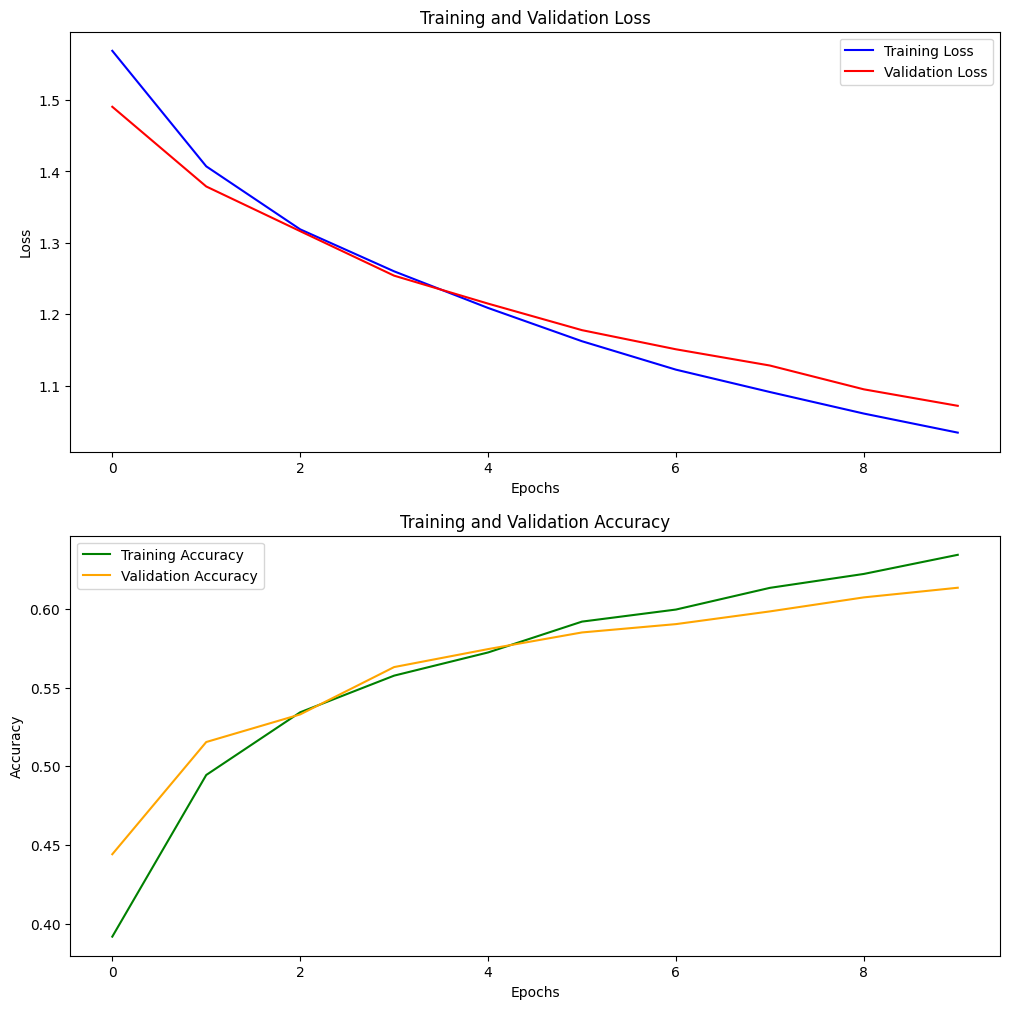

In [90]:
# 主函数
def main():
    fer_path = 'fer2013.csv'
    ferplus_path = 'fer2013new.csv'
    fer_df = pd.read_csv(fer_path)
    ferplus_df = pd.read_csv(ferplus_path)

    # 数据增强
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    train_dataset = FERPlusDataset(fer_df, ferplus_df, data_type='Training', transform=train_transform)
    valid_dataset = FERPlusDataset(fer_df, ferplus_df, data_type='PrivateTest')
    test_dataset = FERPlusDataset(fer_df, ferplus_df, data_type='PublicTest')

    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NineLayerCNN().to(device)

    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.0001
    # 正则化：添加 L2 正则化（权重衰减）
    weight_decay = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = 10
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().tolist())
            train_labels.extend(labels.cpu().tolist())

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        valid_loss, valid_accuracy = evaluate_model(model, valid_dataloader, criterion, device, is_final=False)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        print(f"Epoch {epoch + 1} Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    print("Training Finished. Training Set Evaluation:")
    evaluate_model(model, train_dataloader, criterion, device, is_final=True)

    print("Validation Set Final Evaluation:")
    evaluate_model(model, valid_dataloader, criterion, device, is_final=True)

    print("Test Set Evaluation:")
    evaluate_model(model, test_dataloader, criterion, device, is_final=True)

    # 训练过程可视化
    plt.figure(figsize=(12, 12))

    # 绘制损失曲线
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(valid_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(valid_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


if __name__ == "__main__":
    main()